Importation des librairies:

à installer: 

- scikit-learn : https://scikit-learn.org/stable/install.html
- torch : https://pytorch.org/get-started/locally/

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import math
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from torchsummary import summary

Enlever les données sans déplacement, convertir en heures décimales et déterminer les colonnes à utiliser pour le modèle

In [101]:
fn = 'Enquete_OD_2013_dom108_v3.csv'
df = pd.read_csv(fn,delimiter=';')
df = df.drop(df[df.D_DESRMR ==0].index)
df = df.drop(df[df.D_ORIRMR ==0].index)
cols = ['P_SEXE','P_GRAGE','D_HREDE','D_ORIXCOOR','D_ORIYCOOR','D_DESTXCOOR','D_DESTYCOOR','D_MODE']
ncols = len(cols)
df = df[cols]
df.D_HREDE = (df.D_HREDE//100)+(df.D_HREDE%100)/60
df

,P_SEXE,P_GRAGE,D_HREDE,D_ORIXCOOR,D_ORIYCOOR,D_DESTXCOOR,D_DESTYCOOR,D_MODE
0,1,14,9.50,291500,5045500,291500,5045500,MV
1,1,14,10.50,291500,5045500,291500,5045500,MV
2,1,14,12.00,291500,5045500,292500,5045500,MV
3,1,14,13.00,292500,5045500,291500,5045500,MV
4,1,14,14.00,291500,5045500,291500,5045500,MV
...,...,...,...,...,...,...,...,...
12170,1,5,27.00,298500,5042500,292500,5047500,AC
12171,2,5,13.00,294500,5045500,294500,5046500,MV
12172,2,5,13.75,294500,5046500,294500,5045500,MV
12173,2,5,16.00,294500,5045500,299500,5038500,TC


Fonction pour convertir les  données en valeurs entre 0 et 1. On peut choisir quand est ce qu'on convertis en format catégoriel ou continu. Les données sur les modes sont préalablement converties en nombre également

La fonction de décodage qui fait l'inverse est aussi définie ici

In [104]:
def preprocess_data(df):
    # Dictionary to hold the preprocessing objects for each column
    preprocessors = {}
    
    # List to store processed column arrays
    processed_columns = []

    df.D_MODE[df.D_MODE == 'AC'] = 1
    df.D_MODE[df.D_MODE == 'AP'] = 2
    df.D_MODE[df.D_MODE == 'KR'] = 3
    df.D_MODE[df.D_MODE == 'MV'] = 4
    df.D_MODE[df.D_MODE == 'PR'] = 5
    df.D_MODE[df.D_MODE == 'TC'] = 6
    df.D_MODE[df.D_MODE == 'AJ'] = 7
           
    
    for col in df.columns:
        column = df[col]
        
        # Determine if the column is categorical-like based on unique values
        unique_values = column.nunique()
        
        if unique_values < 1:  # Assume categorical-like if < 10 unique values
            # One-hot encode the column
            encoder = OneHotEncoder(sparse_output = False)
            column_encoded = encoder.fit_transform(column.values.reshape(-1, 1))
            processed_columns.append(column_encoded)
            preprocessors[col] = {"encoder": encoder}
        else:
            # Apply min-max scaling to the column
            scaler = MinMaxScaler()
            column_scaled = scaler.fit_transform(column.values.reshape(-1, 1))
            processed_columns.append(column_scaled)
            preprocessors[col] = {"scaler": scaler}
    
    # Concatenate all processed columns horizontally
    processed_data = np.hstack(processed_columns)
    
    return processed_data, preprocessors

def decode_fake_data(fake_data_encoded, preprocessors, original_columns):
    decoded_columns = []
    index = 0

    for col in original_columns:
        # Get the number of unique values in the original column
        if col in preprocessors:
            if "encoder" in preprocessors[col]:
                # This column was one-hot encoded, reverse it
                encoder = preprocessors[col]["encoder"]
                num_classes = encoder.categories_[0].size
                # Take the one-hot encoded slice for this column
                column_encoded = fake_data_encoded[:, index:index + num_classes]
                column_decoded = np.argmax(column_encoded, axis=1)  # Get original class index
                decoded_columns.append(column_decoded)
                index += num_classes
            elif "scaler" in preprocessors[col]:
                # This column was scaled, reverse the scaling
                scaler = preprocessors[col]["scaler"]
                column_scaled = fake_data_encoded[:, index:index + 1]
                column_decoded = scaler.inverse_transform(column_scaled)  # Reverse the scaling
                decoded_columns.append(column_decoded.astype(int))
                index += 1
    
    # Convert the list of decoded columns into a DataFrame
    decoded_df = pd.DataFrame(np.column_stack(decoded_columns), columns=original_columns)

    decoded_df.P_SEXE+=1
    decoded_df.P_GRAGE+=2
    decoded_df.D_MODE+=1
    
    
    return decoded_df

processed_data,preprocessors = preprocess_data(df)

ncols = processed_data.shape[1]

C:\Users\latitude\AppData\Local\Temp\ipykernel_13880\3438452344.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.D_MODE[df.D_MODE == 'AC'] = 1
C:\Users\latitude\AppData\Local\Temp\ipykernel_13880\3438452344.py:8: SettingWithCopyWarning

Préparation des données pour le modèle, on voit qu'une entrée est un vecteur de 8 colonnes entre 0 et 1, ce qui correspond à notre encodage dans l'espace latent.

In [105]:
train_data_length = 32*(len(processed_data)//32)
processed_data_s = np.array(pd.DataFrame(processed_data).sample(train_data_length))
train_data = torch.zeros((train_data_length,ncols))
for i in range(ncols):
    train_data[:train_data_length, i] = torch.from_numpy(processed_data_s[:train_data_length,i])

train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]
train_data[1]

tensor([0.0000, 0.7143, 0.4162, 0.4308, 0.3373, 0.3538, 0.2892, 0.1667])

In [106]:
df

,P_SEXE,P_GRAGE,D_HREDE,D_ORIXCOOR,D_ORIYCOOR,D_DESTXCOOR,D_DESTYCOOR,D_MODE
0,1,14,9.50,291500,5045500,291500,5045500,4
1,1,14,10.50,291500,5045500,291500,5045500,4
2,1,14,12.00,291500,5045500,292500,5045500,4
3,1,14,13.00,292500,5045500,291500,5045500,4
4,1,14,14.00,291500,5045500,291500,5045500,4
...,...,...,...,...,...,...,...,...
12170,1,5,27.00,298500,5042500,292500,5047500,1
12171,2,5,13.00,294500,5045500,294500,5046500,4
12172,2,5,13.75,294500,5046500,294500,5045500,4
12173,2,5,16.00,294500,5045500,299500,5038500,6


In [107]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

Définitions des architectures du discriminateur et du générateur

In [108]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            #nn.Linear(ncols, 1024),
            #nn.ReLU(),
            #nn.Dropout(0.3),
            #nn.Linear(1024, 512),
            #nn.ReLU(),
            #nn.Dropout(0.3),
            nn.Linear(ncols, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

discriminator = Discriminator()

In [109]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(ncols, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, ncols)
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

In [110]:
summary(discriminator,input_size = (1,1,ncols)),summary(generator,(1,1,ncols))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1            [-1, 1, 1, 256]           2,304
              ReLU-2            [-1, 1, 1, 256]               0
           Dropout-3            [-1, 1, 1, 256]               0
            Linear-4            [-1, 1, 1, 128]          32,896
              ReLU-5            [-1, 1, 1, 128]               0
           Dropout-6            [-1, 1, 1, 128]               0
            Linear-7             [-1, 1, 1, 64]           8,256
              ReLU-8             [-1, 1, 1, 64]               0
           Dropout-9             [-1, 1, 1, 64]               0
           Linear-10              [-1, 1, 1, 1]              65
          Sigmoid-11              [-1, 1, 1, 1]               0
Total params: 43,521
Trainable params: 43,521
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

(None, None)

In [111]:
lr_g = 0.001
lr_d = 0.001
num_epochs = 100 
loss_function= nn.BCELoss()

In [112]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr_d)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr_g)
G_loss = []
D_loss = []

Entrainement du modèle:

In [113]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, ncols))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size,ncols))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()
        
        
        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")
    G_loss.append(loss_generator.item())
    D_loss.append(loss_discriminator.item())

Epoch: 0 Loss D.: 0.2666901648044586
Epoch: 0 Loss G.: 2.27679705619812
Epoch: 10 Loss D.: 0.4075610041618347
Epoch: 10 Loss G.: 1.1185271739959717
Epoch: 20 Loss D.: 0.4356401860713959
Epoch: 20 Loss G.: 1.233017086982727
Epoch: 30 Loss D.: 0.4911321997642517
Epoch: 30 Loss G.: 1.1203185319900513
Epoch: 40 Loss D.: 0.32624876499176025
Epoch: 40 Loss G.: 1.3165680170059204
Epoch: 50 Loss D.: 0.4339800179004669
Epoch: 50 Loss G.: 1.393404483795166
Epoch: 60 Loss D.: 0.6316084861755371
Epoch: 60 Loss G.: 1.4854185581207275
Epoch: 70 Loss D.: 0.4303188920021057
Epoch: 70 Loss G.: 1.4247779846191406
Epoch: 80 Loss D.: 0.5000856518745422
Epoch: 80 Loss G.: 1.4957005977630615
Epoch: 90 Loss D.: 0.4893576502799988
Epoch: 90 Loss G.: 1.4198522567749023


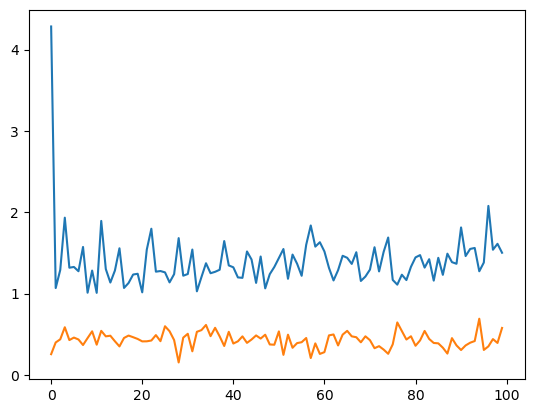

In [114]:
fig, ax = plt.subplots()
ax.plot(G_loss)
ax.plot(D_loss)

In [115]:
latent_space_samples = torch.randn(1000, ncols)
generated_samples = generator(latent_space_samples)

In [116]:
generated_samples = generated_samples.detach()
#plt.plot(train_data[:,3+2],train_data[:,4+2],'.',alpha = 0.1)
#plt.plot(generated_samples[:, 4+2], generated_samples[:, 4+2], ".")
fake_df = decode_fake_data(generated_samples,preprocessors,cols)

Analyse des distributions des résultats générés.

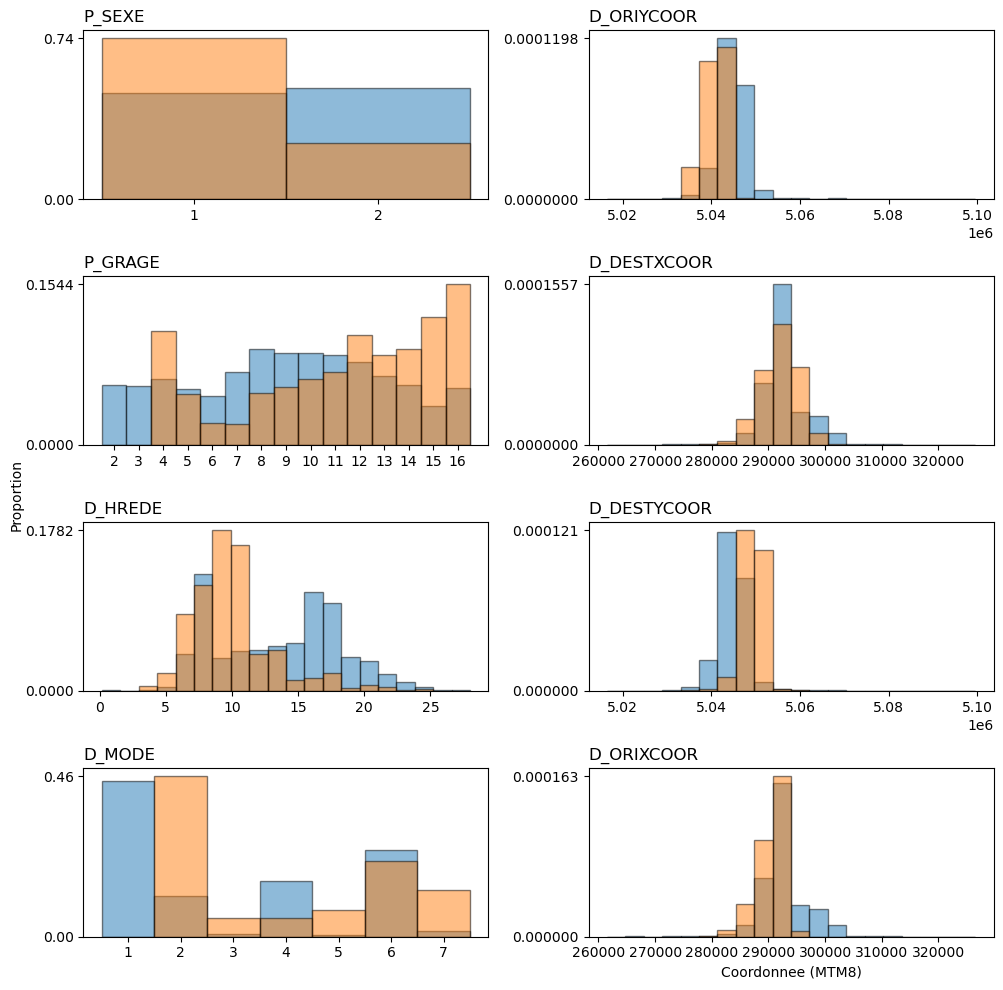

In [117]:
fig, ax = plt.subplots(4,2, figsize = (10,10))

for i in range(len(df.columns)):
    unique_values = df[df.columns[i]].nunique()
    col = 0
    if df.columns[i][-4:]=='COOR':
        col = 1
        
    cat = False
    if unique_values < 20:
        bins = np.arange(np.min(df[df.columns[i]])-0.5,np.max(df[df.columns[i]])+1.5,1)
        cat = True
    else:
        bins = 20
    n,bins,_ = ax[i%4][col].hist(df[df.columns[i]], density = True, alpha = 0.5,bins = bins,edgecolor = 'k')
    n2,bins2,_ = ax[i%4][col].hist(fake_df[fake_df.columns[i]],density = True,alpha = 0.5,bins = bins,edgecolor = 'k')
    ax[i%4][col].set_title(df.columns[i],loc = 'left')
    if cat == True:
        ax[i%4][col].set_xticks(bins[:-1]+0.5,(bins[:-1]+0.5).astype(int))

    ax[i%4][col].set_yticks([0,np.max([n,n2])])
#fig.legend(['Enquete OD','Artificiel'], loc = 'upper center')

fig.text(0.0, 0.5, 'Proportion', va='center', rotation='vertical')
ax[-1,1].set_xlabel('Coordonnee (MTM8)')
fig.tight_layout()
fig.savefig('Figures/lrd_{}_lrg_{}_epochs_{}_cats.png'.format(lr_d,lr_g,epoch))

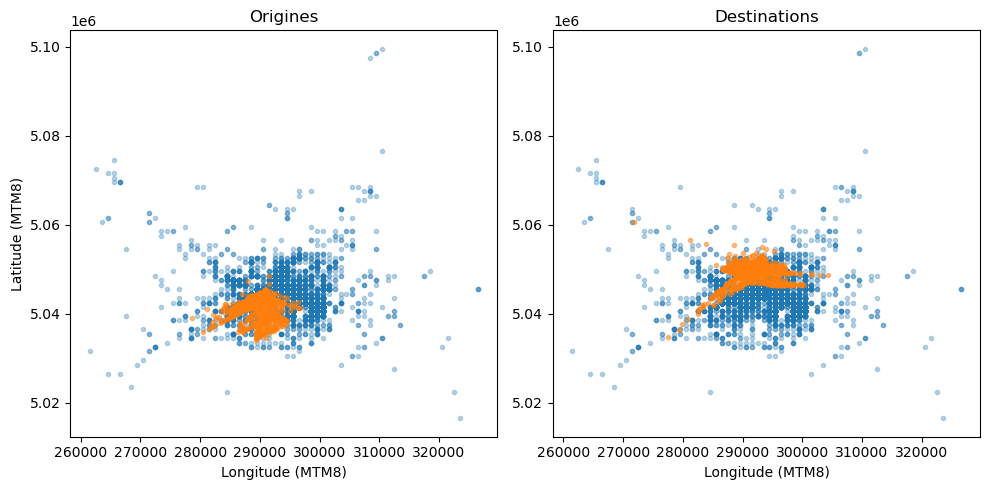

In [118]:
fig, ax = plt.subplots(1,2,figsize = (10,5))
ax[0].plot(df.D_ORIXCOOR,df.D_ORIYCOOR,'.', alpha = 0.3)
ax[0].plot(fake_df.D_ORIXCOOR,fake_df.D_ORIYCOOR,'.',alpha = 0.5)
ax[1].plot(df.D_DESTXCOOR,df.D_DESTYCOOR,'.', alpha = 0.3)
ax[1].plot(fake_df.D_DESTXCOOR,fake_df.D_DESTYCOOR,'.',alpha = 0.5)

ax[0].set_xlabel('Longitude (MTM8)')
ax[1].set_xlabel('Longitude (MTM8)')
ax[0].set_title('Origines')
ax[1].set_title('Destinations')

ax[0].set_ylabel('Latitude (MTM8)')

fig.tight_layout()
fig.savefig('Figures/lrd_{}_lrg_{}_epochs_{}_coords.png'.format(lr_d,lr_g,epoch))

In [119]:
fake_df.D_MODE[fake_df.D_MODE == 1] = 'AC'
fake_df.D_MODE[fake_df.D_MODE == 2] = 'AP'
fake_df.D_MODE[fake_df.D_MODE == 3] = 'KR'
fake_df.D_MODE[fake_df.D_MODE == 4] = 'MV'
fake_df.D_MODE[fake_df.D_MODE == 5] = 'PR'
fake_df.D_MODE[fake_df.D_MODE == 6] = 'TC'
fake_df.D_MODE[fake_df.D_MODE == 7] = 'AJ'

C:\Users\latitude\AppData\Local\Temp\ipykernel_13880\3419317066.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  fake_df.D_MODE[fake_df.D_MODE == 1] = 'AC'
C:\Users\latitude\AppData\Local\Temp\ipykernel_13880\3419317066.py:2: FutureWarnin

In [120]:
fake_df.to_csv('synthetic_data/lrd_{}_lrg_{}_epochs_{}.csv'.format(lr_d,lr_g,epoch),index = False)

In [126]:
def compute_distances(df):
    dists = ((df.D_DESTXCOOR-df.D_ORIXCOOR)**2-(df.D_DESTYCOOR-df.D_ORIYCOOR)**2)**0.5
    return dists

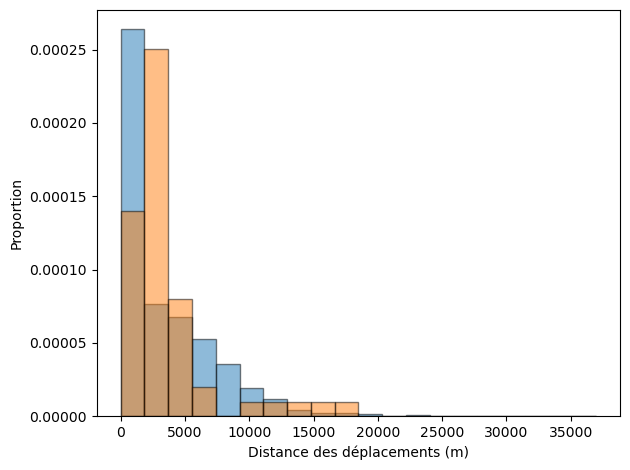

In [138]:
truedists = compute_distances(df)
fakedists = compute_distances(fake_df)

fig, ax = plt.subplots()
n,bins,_ = ax.hist(truedists,bins = 20, alpha = 0.5,edgecolor = 'k',density = True)
ax.hist(fakedists, bins = bins, alpha = 0.5, edgecolor = 'k',density = True)
ax.set_xlabel('Distance des déplacements (m)')
ax.set_ylabel('Proportion')
fig.tight_layout()
fig.savefig('Figures/GAN_distances.png',dpi = 200)